In [144]:
def read_test_cases_from_txt(filename):
    with open(filename, "r") as f:
        data = f.read()

    # Parse the input data
    lines = data.strip().split("\n")
    n, e, _ = map(int, lines[0].split())
    edges = [tuple(map(int, line.split())) for line in lines[1:1+e]]
    queries = [tuple(map(int, line.split())) for line in lines[1+e:]]
    
    return n, edges, queries

# Test the function with our input file
n, edges, queries = read_test_cases_from_txt("./Example_LAB7.txt")
n, edges, 

(7,
 [(1, 2, 50),
  (1, 3, 60),
  (2, 4, 120),
  (2, 5, 90),
  (3, 6, 50),
  (4, 6, 80),
  (4, 7, 70),
  (5, 7, 40),
  (6, 7, 140)])

In [145]:
def min_max_noise(n, edges, queries):
    # Initialize the distance matrix with infinity and set diagonal to 0
    dist = [[float('inf')] * n for _ in range(n)]
    for i in range(n):
        dist[i][i] = 0

    # Fill initial distances with edge weights
    for u, v, w in edges:
        dist[u-1][v-1] = w
        dist[v-1][u-1] = w

    # Floyd-Warshall modified algorithm
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], max(dist[i][k], dist[k][j]))

    # Answer the queries
    results = []
    for u, v in queries:
        if dist[u-1][v-1] == float('inf'):
            results.append("no path")
        else:
            results.append(dist[u-1][v-1])

    return results


result = min_max_noise(n, edges, queries)
print(result)


[80, 60, 60]


In [146]:
import networkx as nx
import matplotlib.pyplot as plt

In [147]:
def floyd_warshall_with_path(n, edges):
    """Computes the distance matrix using the Floyd-Warshall algorithm and also returns the predecessor matrix for path tracing."""
    # Initialize the distance matrix with infinity and set diagonal to 0
    dist = [[float('inf')] * n for _ in range(n)]
    pred = [[None] * n for _ in range(n)]  # Predecessor matrix
    for i in range(n):
        dist[i][i] = 0

    # Fill initial distances with edge weights
    for u, v, w in edges:
        dist[u-1][v-1] = w
        dist[v-1][u-1] = w
        pred[u-1][v-1] = u
        pred[v-1][u-1] = v

    # Floyd-Warshall modified algorithm
    for k in range(n):
        for i in range(n):
            for j in range(n):
                # Update the distance and predecessor matrix
                if dist[i][j] > max(dist[i][k], dist[k][j]):
                    dist[i][j] = max(dist[i][k], dist[k][j])
                    pred[i][j] = pred[k][j]

    return dist, pred

def trace_path_from_pred(u, v, pred):
    """Trace the path from node u to node v based on the predecessor matrix."""
    if pred[u-1][v-1] is None:
        return []

    path = [v]
    while path[-1] != u:
        path.append(pred[u-1][path[-1]-1])
    path.reverse()

    return path

# Compute distance and predecessor matrices
dist_matrix, pred_matrix = floyd_warshall_with_path(n, edges)

# Test the trace_path_from_pred function
paths = [trace_path_from_pred(u, v, pred_matrix) for u, v in queries]
paths


[[1, 3, 6, 4, 7], [2, 1, 3, 6], [6, 3, 1, 2]]

Path from node 1 to node 7: [1, 3, 6, 4, 7]


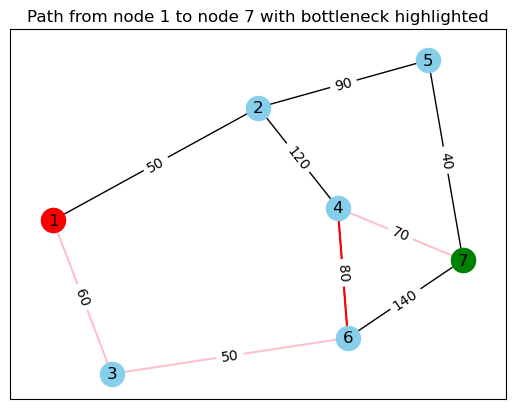

----------------------------------------
Path from node 2 to node 6: [2, 1, 3, 6]


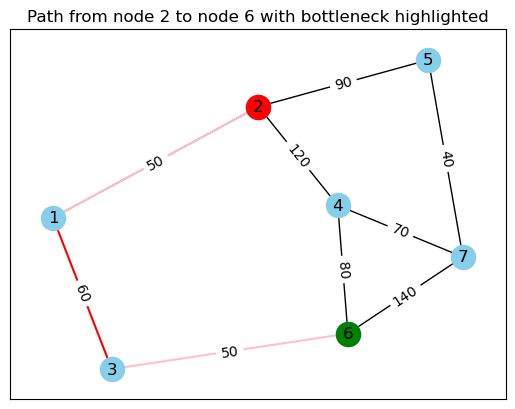

----------------------------------------
Path from node 6 to node 2: [6, 3, 1, 2]


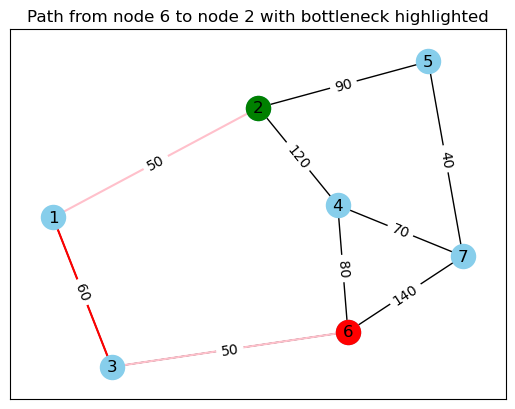

----------------------------------------


In [150]:
def draw_query_path_with_ans_highlight(n, edges, queries, pred_matrix):
    # Create a base graph
    G = nx.Graph()
    
    # Add nodes
    for i in range(1, n + 1):
        G.add_node(i)
    
    # Add edges with weights
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)

    for u, v in queries:
        # Copy the base graph to ensure modifications don't affect other visualizations
        G_copy = G.copy()
        
        path = trace_path_from_pred(u, v, pred_matrix)
        print(f"Path from node {u} to node {v}: {path}")
        
        # If no path exists, just draw the graph without highlighting anything
        if not path:
            pos = nx.circular_layout(G_copy)
            nx.draw(G_copy, pos, with_labels=True, node_size=100, node_color='pink')
            edge_labels = {(u, v): G_copy[u][v]['weight'] for u, v in G_copy.edges()}
            # Highlight the start and end nodes
            nx.draw_networkx_nodes(G_copy, pos, nodelist=[u], node_color='green')
            nx.draw_networkx_nodes(G_copy, pos, nodelist=[v], node_color='red')
            
            nx.draw_networkx_edge_labels(G_copy, pos, edge_labels=edge_labels)
            plt.title(f"Graph for query from node {u} to node {v}")
            plt.show()
            continue
        
        # Identify the bottleneck edge (edge with maximum weight in the path)
        ans_edge = max([(path[i], path[i+1]) for i in range(len(path)-1)], 
                              key=lambda e: G_copy[e[0]][e[1]]['weight'])
        
        # Draw the graph with path
        pos = nx.spring_layout(G_copy , seed=1234)  # positions for all nodes
        
        # Draw non-path edges in black
        non_path_edges = set(G_copy.edges()) - set([(path[i], path[i+1]) for i in range(len(path)-1)])
        nx.draw_networkx_edges(G_copy, pos, edgelist=non_path_edges, edge_color='black')
        
        # Draw nodes
        nx.draw_networkx_nodes(G_copy, pos, node_size=300, node_color='skyblue')
        
        # Highlight the start and end nodes
        nx.draw_networkx_nodes(G_copy, pos, nodelist=[u], node_color='red')
        nx.draw_networkx_nodes(G_copy, pos, nodelist=[v], node_color='green')
        
        # Highlight the path in blue excluding the bottleneck edge
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1) if (path[i], path[i+1]) != ans_edge]
        nx.draw_networkx_edges(G_copy, pos, edgelist=path_edges, edge_color='pink',width=1.5)
        
        # Highlight the ans edge in red
        nx.draw_networkx_edges(G_copy, pos, edgelist=[ans_edge], edge_color='red',width=1.5)
        
        # Draw labels
        nx.draw_networkx_labels(G_copy, pos)
        
        # Draw edge labels with weights
        edge_labels = {(u, v): G_copy[u][v]['weight'] for u, v in G_copy.edges()}
        nx.draw_networkx_edge_labels(G_copy, pos, edge_labels=edge_labels)
        
        plt.title(f"Path from node {u} to node {v} with bottleneck highlighted")
        plt.show()
        print(f"----------------------------------------")

# Draw the path for each query in the provided test case with the bottleneck highlighted
draw_query_path_with_ans_highlight(n, edges, queries, pred_matrix)
